## Neural network for binary classification
Classification whether the company description belongs to the financial services sector or not. The financial services sector is selected since it is the sector with the most values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
def df_to_dataset(dataframe, column, shuffle=True, batch_size=64):
    """Convert the Pandas' dataset into a tensorflow dataset and shuffle and batch the entries."""
    df = dataframe.copy()
    code = df.pop('label')
    df = dataframe[f'{column}']
    ds = tf.data.Dataset.from_tensor_slices((df, code))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

### Dataset with normal sentences

In [3]:
column = 'description'

df = pd.read_json('..\\06_data_prep.json')
df['label'] = (df.sector == 'Financial Services').astype(int)
df.head()

,description,sector,label
0,Adara Acquisition Corp. does not have signific...,Financial Services,1
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,0
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,1
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,0
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,0


In [4]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [5]:
train_data = df_to_dataset(train, column)
valid_data = df_to_dataset(val, column)
test_data = df_to_dataset(test, column)

In [6]:
# import a token based text embedding on English Google News with pre-built out-of-vocabulary handling
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)
# to show the numerical values after the text embedding
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(64, 50), dtype=float32, numpy=
array([[ 0.6141678 , -0.13839848,  0.5948703 , ..., -0.14087558,
         0.04347822,  0.92792976],
       [ 0.5033029 , -0.38988513,  0.59696835, ..., -0.3757148 ,
        -0.28494933,  0.10478929],
       [ 0.27030474, -0.25589672,  0.43356776, ...,  0.00865496,
        -0.04937749,  0.03635268],
       ...,
       [ 0.925737  , -0.34082898,  0.43715623, ..., -0.43339387,
        -0.5478974 ,  0.6826439 ],
       [ 0.20183922,  0.07590131,  0.27295095, ...,  0.19196524,
        -0.20220171,  0.35402307],
       [ 0.8071863 , -0.47331262,  1.05621   , ..., -0.54644877,
        -0.0475732 ,  0.10994462]], dtype=float32)>

In [7]:
model = tf.keras.Sequential([
    hub.KerasLayer(embedding, dtype=tf.string, trainable=True),  # text to numerical value transformation
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='BinaryCrossentropy',
              metrics=['accuracy'])

In [9]:
# raw accuracy of the model
model.evaluate(train_data)

123/123 [==============================] - 1s 2ms/step - loss: 0.7989 - accuracy: 0.2886


[0.7988614439964294, 0.2885667085647583]

In [10]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
123/123 [==============================] - 50s 406ms/step - loss: 0.3584 - accuracy: 0.8492 - val_loss: 0.2558 - val_accuracy: 0.8785
Epoch 2/5
123/123 [==============================] - 50s 409ms/step - loss: 0.1029 - accuracy: 0.9733 - val_loss: 0.2364 - val_accuracy: 0.9028
Epoch 3/5
123/123 [==============================] - 49s 400ms/step - loss: 0.0655 - accuracy: 0.9851 - val_loss: 0.2567 - val_accuracy: 0.9038
Epoch 4/5
123/123 [==============================] - 49s 401ms/step - loss: 0.0400 - accuracy: 0.9908 - val_loss: 0.2482 - val_accuracy: 0.9160
Epoch 5/5
123/123 [==============================] - 49s 400ms/step - loss: 0.0273 - accuracy: 0.9931 - val_loss: 0.2453 - val_accuracy: 0.9241


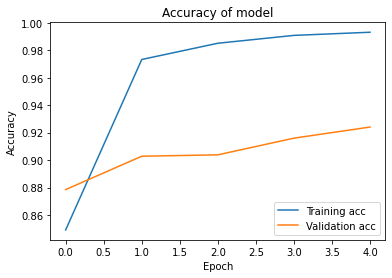

In [11]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

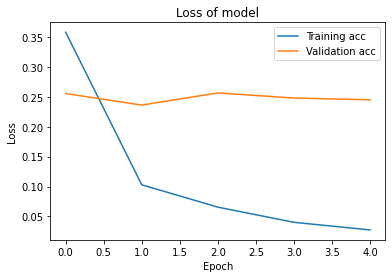

In [12]:
plt.plot(history.history['loss'], label="Training acc")
plt.plot(history.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [13]:
model.evaluate(test_data)

16/16 [==============================] - 1s 48ms/step - loss: 0.0375 - accuracy: 0.9878


[0.03749576583504677, 0.9877800345420837]

### Dataset without stopwords and lemmatization

In [14]:
column = 'explicit_lemmatization'

df = pd.read_json('..\\Unternehmen_preprocessed.json')
df = df[['explicit_lemmatization', 'sector']]
df['label'] = (df.sector == 'Financial Services').astype(int)
df.head()

,explicit_lemmatization,sector,label
0,significant operation company intend effect me...,Financial Services,1
1,immuno pharma company focus research developme...,Healthcare,0
2,Ashford Inc asset management firm firm provide...,Financial Services,1
3,subsidiary operate digital medium platform Uni...,Communication Services,0
4,subsidiary engage wholesale distribution consu...,Consumer Defensive,0


In [15]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [16]:
train_data = df_to_dataset(train, column)
valid_data = df_to_dataset(val, column)
test_data = df_to_dataset(test, column)

In [17]:
# built a neural network for classification with dropout layers to decrease overfitting
model_lemma = tf.keras.Sequential([
    hub.KerasLayer(embedding, dtype=tf.string, trainable=True),  # text to numerical value transformation
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
model_lemma.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='BinaryCrossentropy',
              metrics=['accuracy'])

In [19]:
history_lemma = model_lemma.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
123/123 [==============================] - 51s 409ms/step - loss: 0.3650 - accuracy: 0.8421 - val_loss: 0.2159 - val_accuracy: 0.9068
Epoch 2/5
123/123 [==============================] - 50s 407ms/step - loss: 0.1113 - accuracy: 0.9711 - val_loss: 0.1750 - val_accuracy: 0.9271
Epoch 3/5
123/123 [==============================] - 50s 407ms/step - loss: 0.0687 - accuracy: 0.9847 - val_loss: 0.1853 - val_accuracy: 0.9311
Epoch 4/5
123/123 [==============================] - 50s 406ms/step - loss: 0.0551 - accuracy: 0.9883 - val_loss: 0.1901 - val_accuracy: 0.9321
Epoch 5/5
123/123 [==============================] - 50s 408ms/step - loss: 0.0404 - accuracy: 0.9924 - val_loss: 0.2179 - val_accuracy: 0.9331


In [20]:
model_lemma.evaluate(test_data)

16/16 [==============================] - 1s 48ms/step - loss: 0.0344 - accuracy: 0.9908


[0.03437201306223869, 0.9908257126808167]